# 고객을 세그먼테이션하자! 프로젝트

In [ ]:
select * 
from first-metric-410915.modulabs_project.data
limit 10

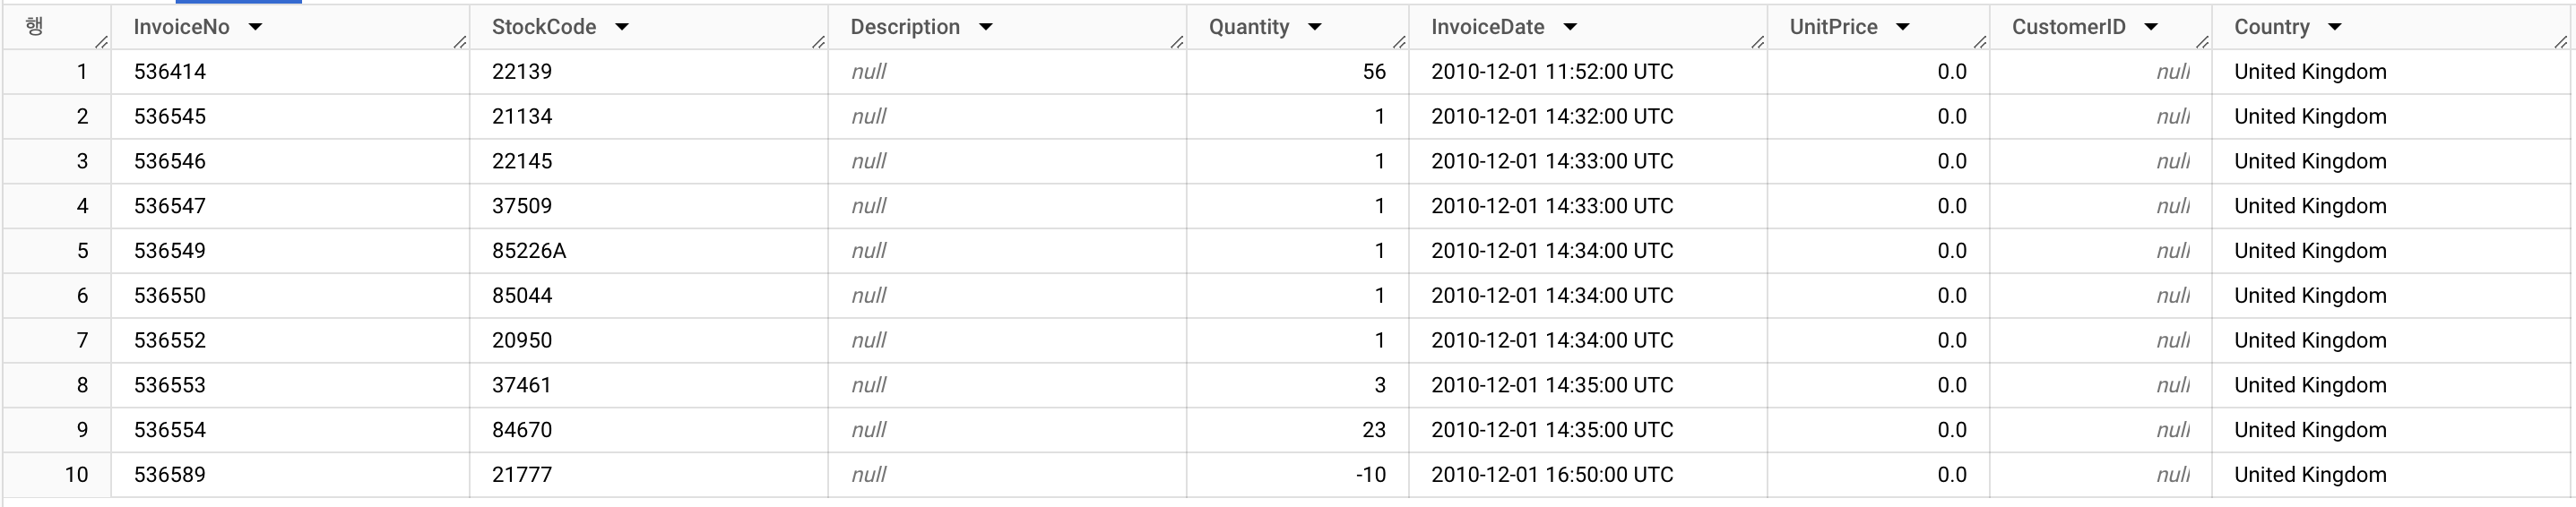

In [ ]:
SELECT COUNT(*) as total_rows
FROM first-metric-410915.modulabs_project.data

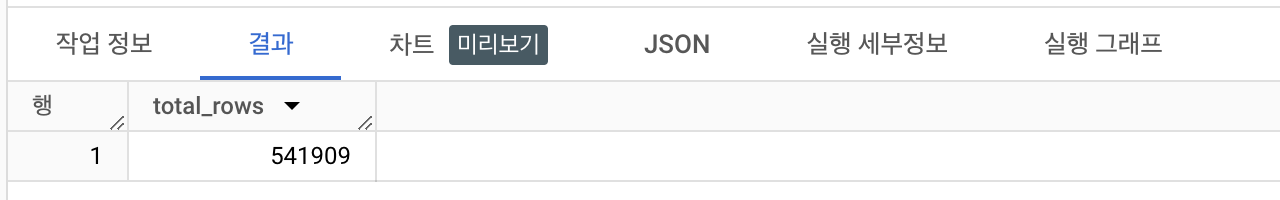

In [ ]:
# 결측치 비율 확인
SELECT COUNT(InvoiceNo) as COUNT_InvoiceNo, COUNT(StockCode) as COUNT_StockCode, COUNT(Description) as COUNT_Description, COUNT(Quantity) as COUNT_Quantity, COUNT(InvoiceDate) as COUNT_InvoiceDate, COUNT(UnitPrice) as COUNT_UnitPrice, COUNT(CustomerID) as COUNT_CustomerID, COUNT(Country) as COUNT_Country
FROM first-metric-410915.modulabs_project.data;

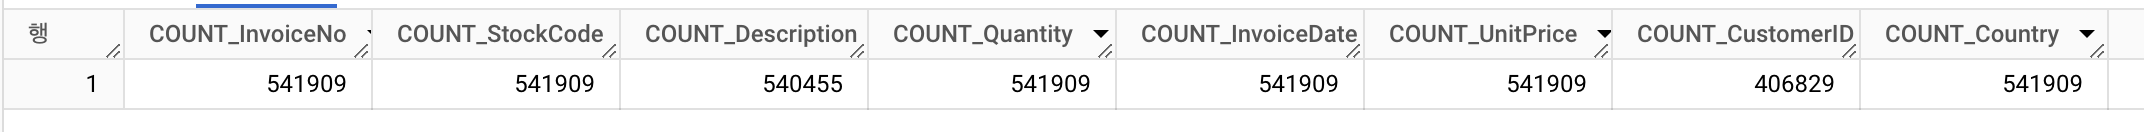

## 1-1. 데이터 전처리 : 결측치 제거

In [ ]:
#  결측치 비율 확인
SELECT
    'InvoiceNo' AS column_name,
    ROUND(SUM(CASE WHEN InvoiceNo IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'StockCode' AS column_name,
    ROUND(SUM(CASE WHEN StockCode IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'Description' AS column_name,
    ROUND(SUM(CASE WHEN Description IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'Quantity' AS column_name,
    ROUND(SUM(CASE WHEN Quantity IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'InvoiceDate' AS column_name,
    ROUND(SUM(CASE WHEN InvoiceDate IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'UnitPrice' AS column_name,
    ROUND(SUM(CASE WHEN UnitPrice IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'CustomerID' AS column_name,
    ROUND(SUM(CASE WHEN CustomerID IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data
UNION ALL
SELECT
    'Country' AS column_name,
    ROUND(SUM(CASE WHEN Country IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM first-metric-410915.modulabs_project.data

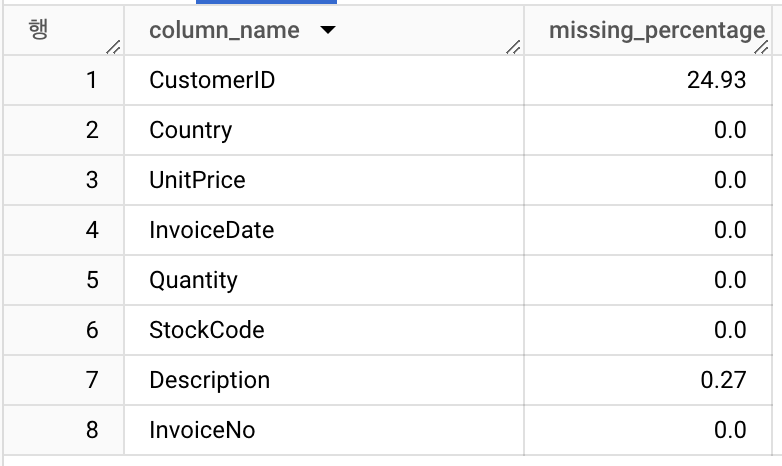

In [ ]:
# Description 확인
SELECT DISTINCT Description
FROM first-metric-410915.modulabs_project.data
WHERE StockCode = '85123A'

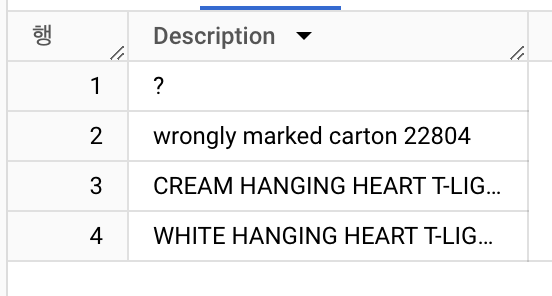

In [ ]:
# 결측치 처리
DELETE FROM first-metric-410915.modulabs_project.data
WHERE Description IS NULL 
OR CustomerID IS NULL;

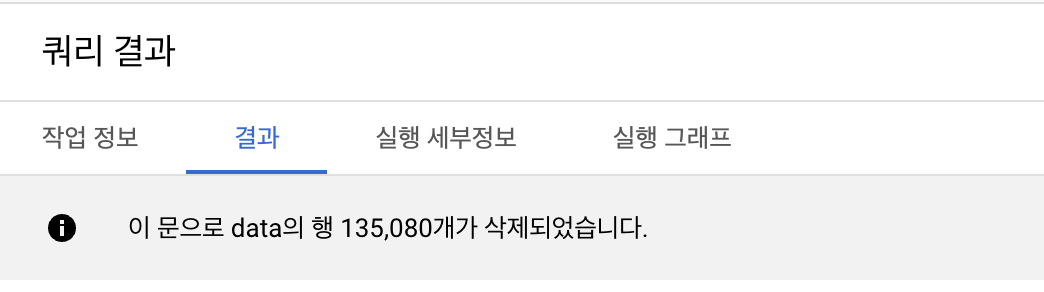

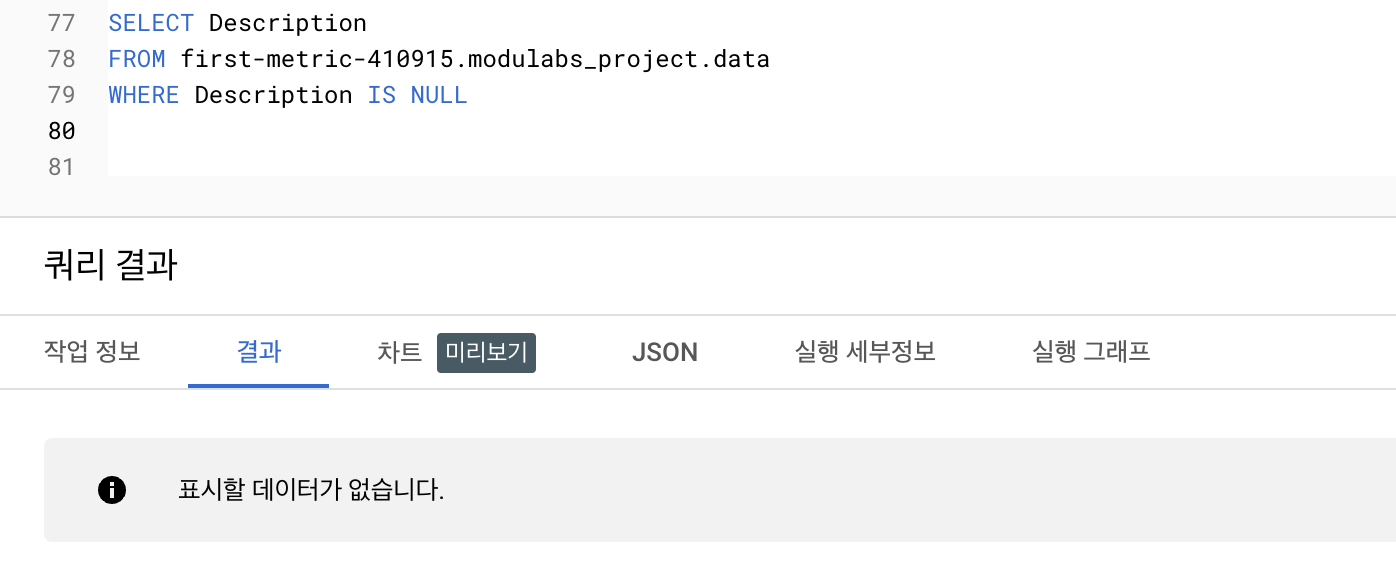

## 1-2 데이터 전처리: 중복값 처리

In [ ]:
# 중복값 확인
WITH DUPLICATE AS (
  SELECT InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, COUNT(*) as row_count
  FROM first-metric-410915.modulabs_project.data
  GROUP BY 1,2,3,4,5,6,7,8
)
SELECT *
FROM DUPLICATE
WHERE DUPLICATE.row_count > 1

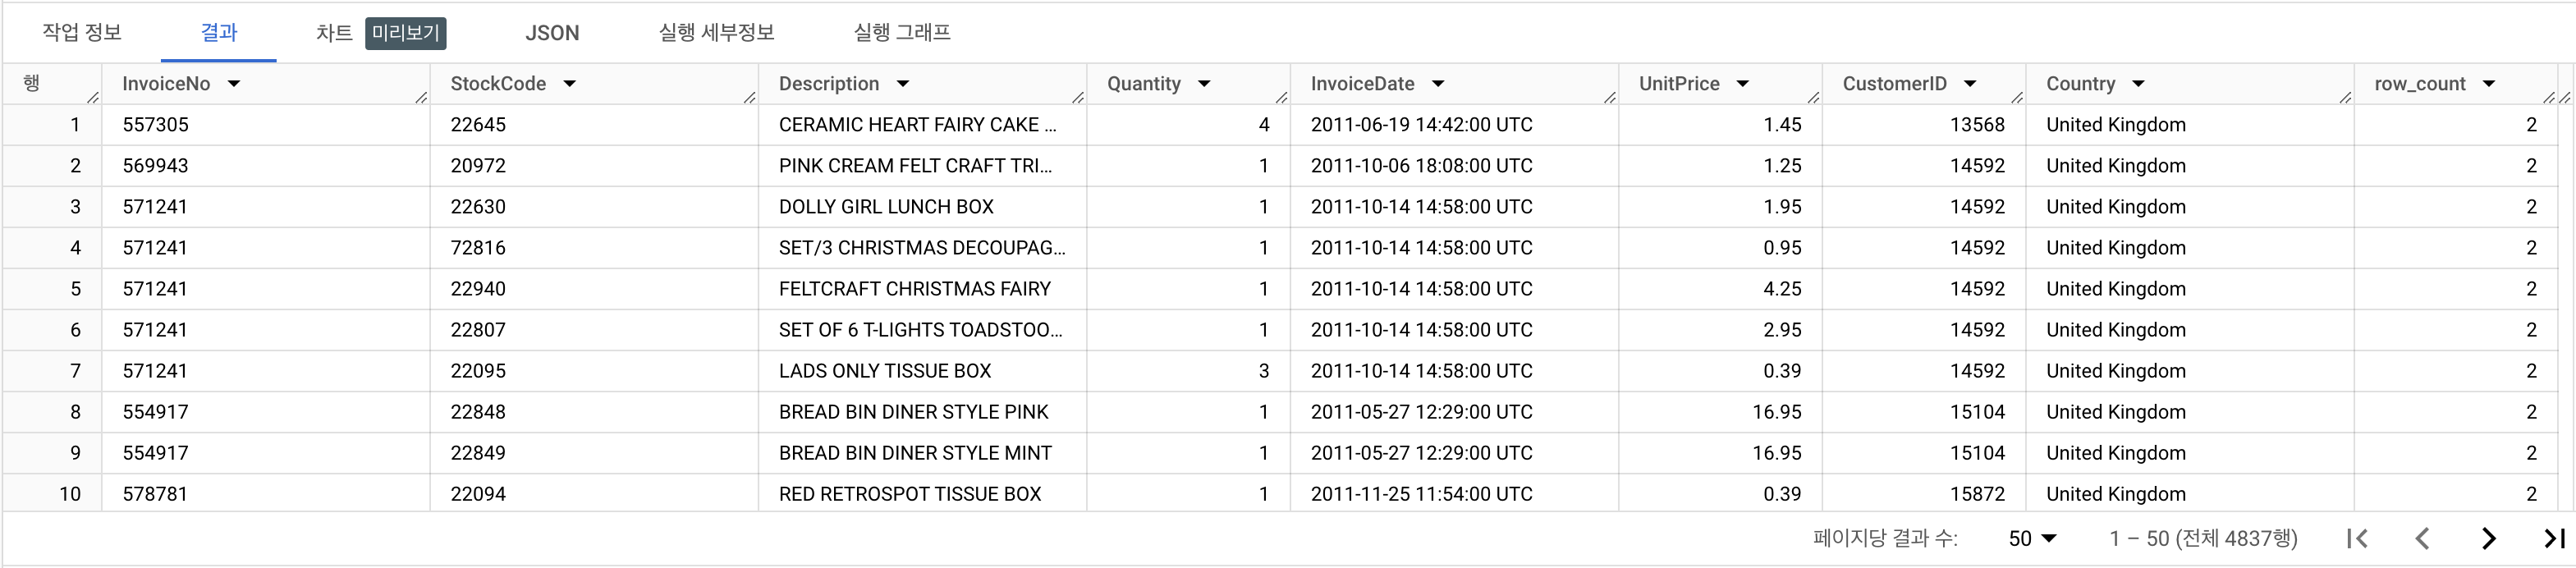

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.data AS
SELECT DISTINCT *
FROM first-metric-410915.modulabs_project.data;

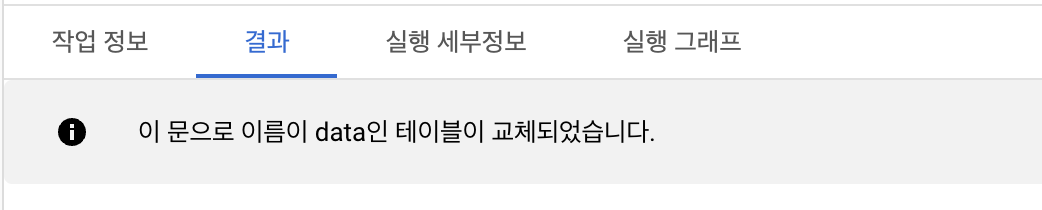

In [ ]:
SELECT COUNT(*) 
FROM first-metric-410915.modulabs_project.data;

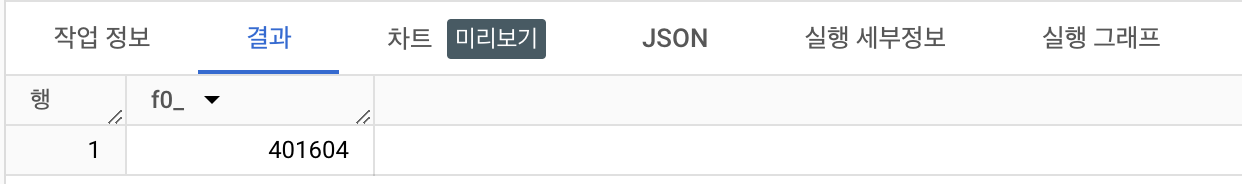

In [ ]:
SELECT COUNT(DISTINCT InvoiceNo) 
FROM first-metric-410915.modulabs_project.data;

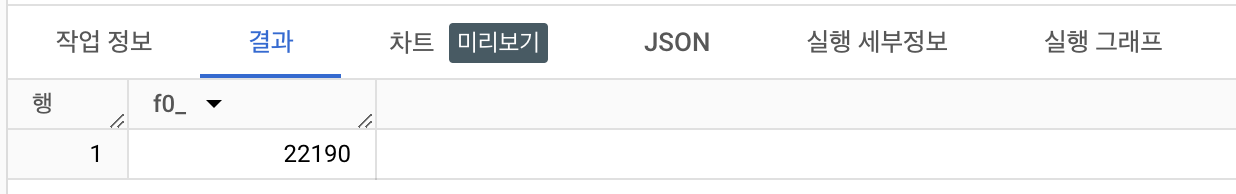

In [ ]:
SELECT DISTINCT InvoiceNo
FROM first-metric-410915.modulabs_project.data
LIMIT 100

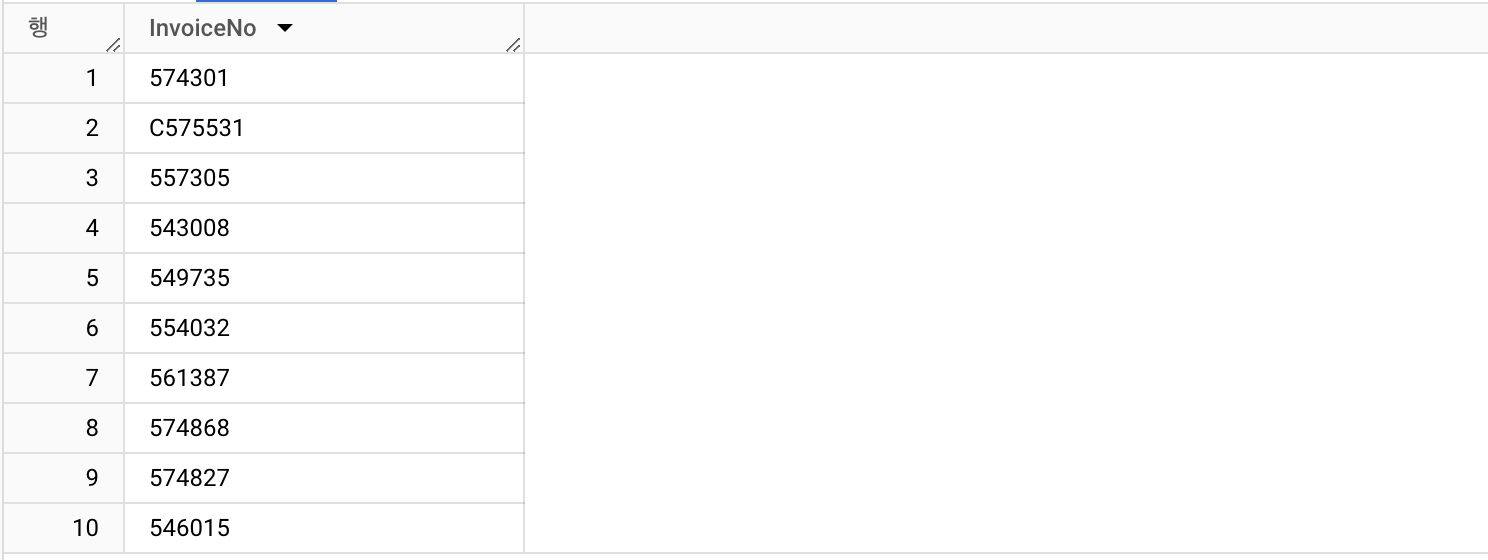

## 1-3 데이터 전처리: 오류값 처리

In [ ]:
SELECT *
FROM first-metric-410915.modulabs_project.data
WHERE InvoiceNo LIKE 'C%'
LIMIT 100

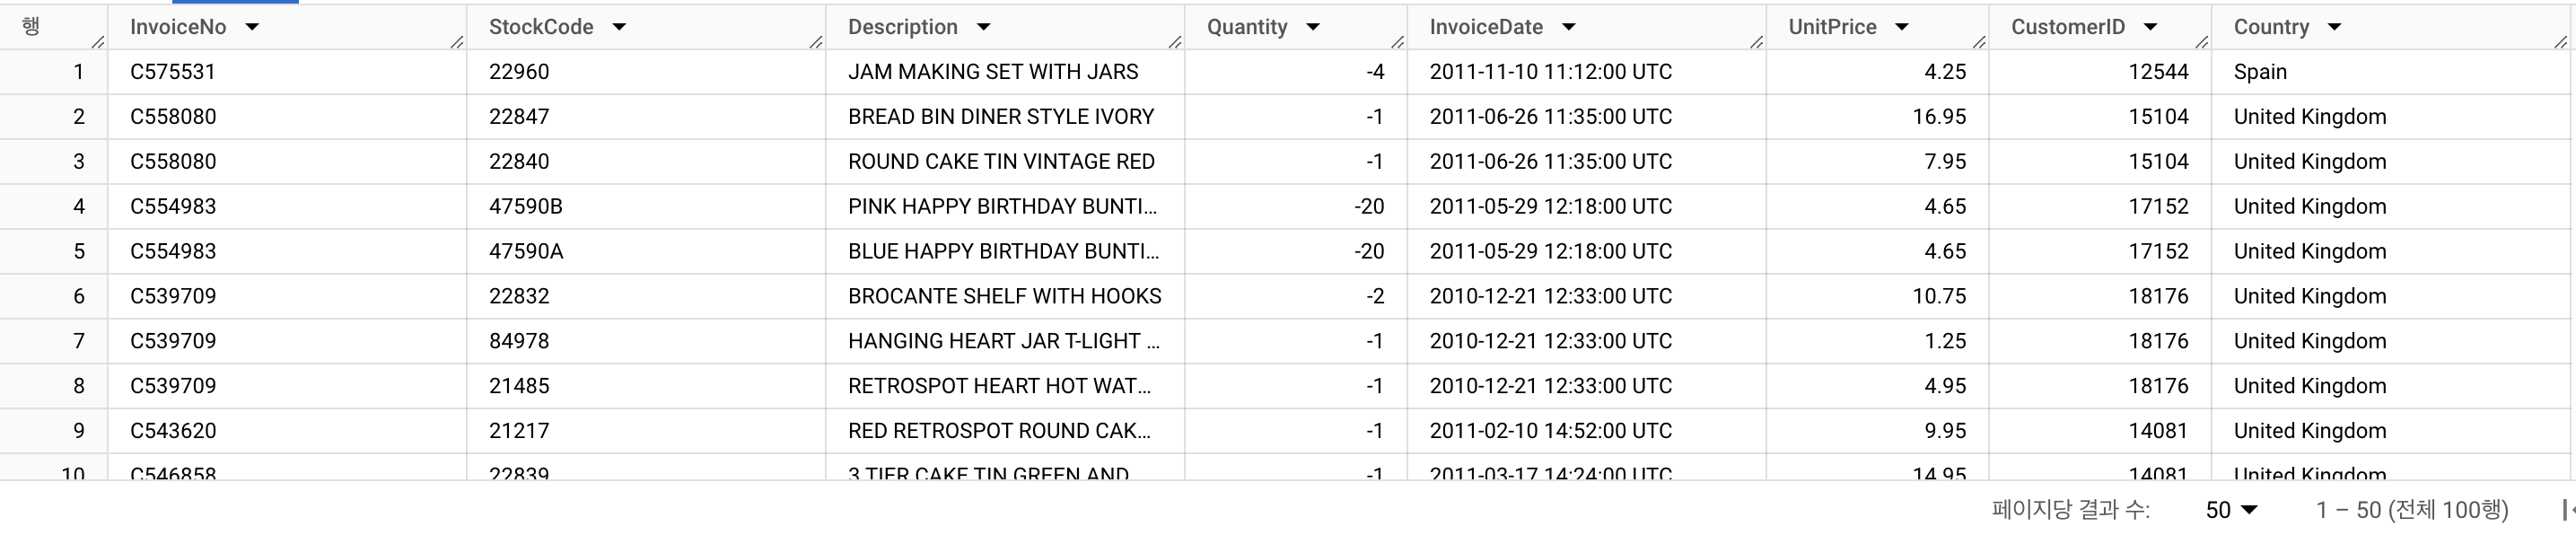

여기서 발견할 수 있는 특이한 경향성
100건 중 2 건 제외 전부 United Kingdom 에서 구매한 데이터 => 단순히 취소 데이터가 많은 건지 애초에 그 국가에서 많이 이용하는 건지 확인해봐야 함 <Br/>Quantity가 음수
전체 취소건은 8872건인데 이 중 취소한 물품은 3654 종류 여러 고객이 구매 취소하는 몇몇 물품들이 몰려 있을 가능성 있따.

In [ ]:
SELECT concat(ROUND(SUM(CASE WHEN InvoiceNo LIKE 'C%' THEN 1 ELSE 0 END)/ COUNT(InvoiceNo) * 100, 1), "%") as cancellations
FROM first-metric-410915.modulabs_project.data;

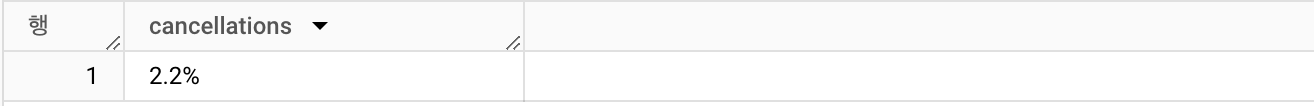

In [ ]:
SELECT COUNT(DISTINCT StockCode) 
FROM first-metric-410915.modulabs_project.data

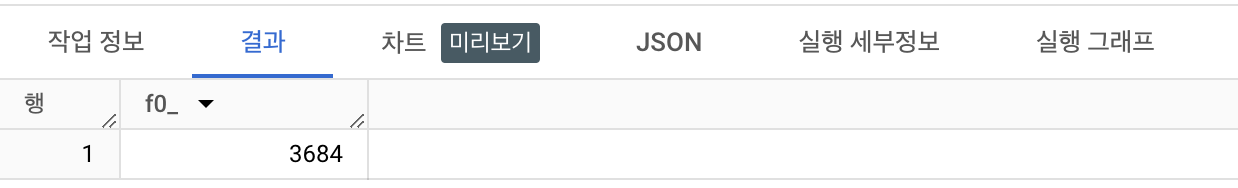

In [ ]:
SELECT StockCode, COUNT(*) AS sell_cnt 
FROM first-metric-410915.modulabs_project.data
GROUP BY 1
ORDER BY sell_cnt DESC
LIMIT 10

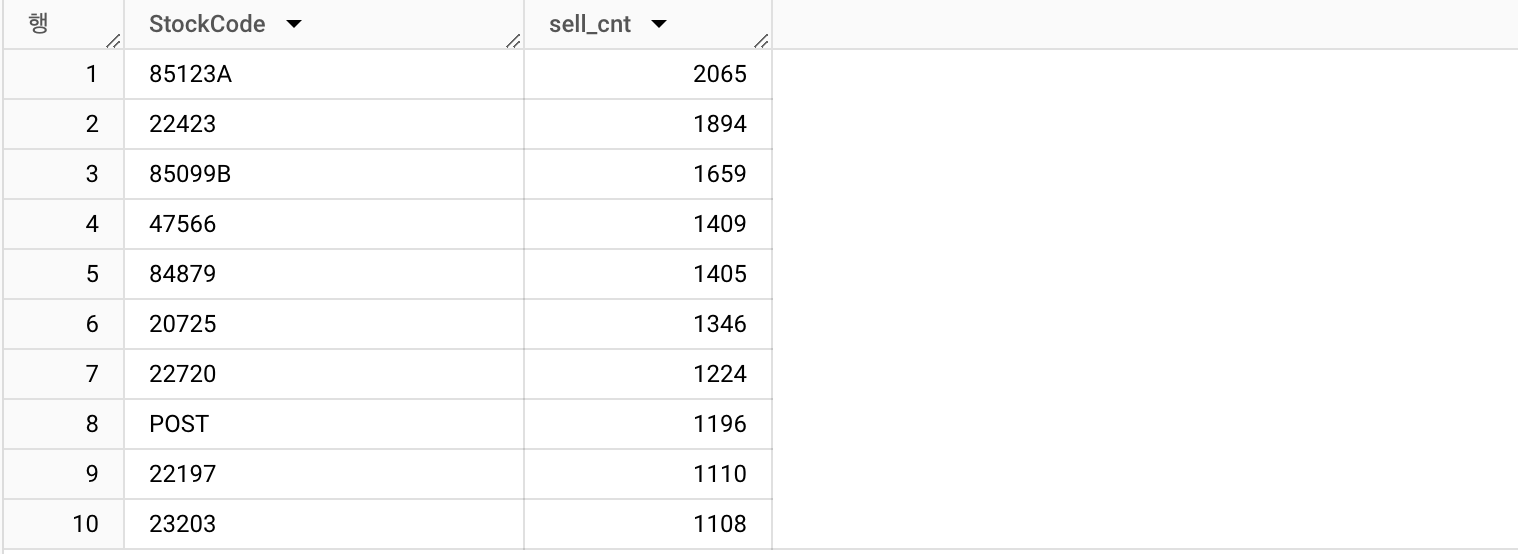

### 인사이트
먼저 파악할 수 있는 건 대부분의 StockCode들은 5-6 자리 숫자라는 점.   
그래서 StockCode 중 'POST'는 이상치 같아 보인다.   
- 그 이상의 정보는 StockCode 자체만 봤을 때는 파악하기 어렵다.   
- 다른 StockCode와는 확연히 POST가 뭔지 확인해봐야할 것 같다. 5자리 숫자 끝에 붙은 A, B는 분류 기준으로 보인다.   

In [ ]:
WITH UniqueStockCodes AS (
  SELECT DISTINCT StockCode
  FROM first-metric-410915.modulabs_project.data
)
SELECT
  LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count,
  COUNT(*) AS stock_cnt
FROM UniqueStockCodes
GROUP BY number_count
ORDER BY stock_cnt DESC;

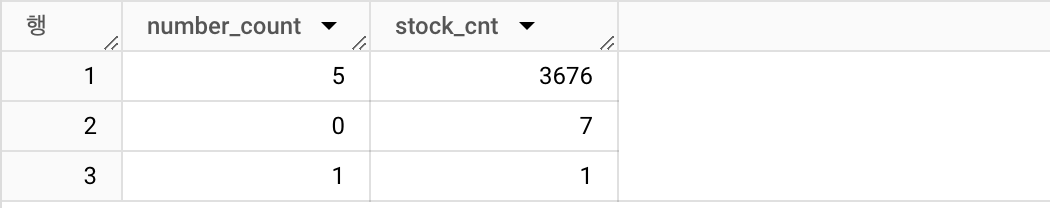

In [ ]:
SELECT DISTINCT StockCode, number_count
FROM (
  SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM first-metric-410915.modulabs_project.data
) 
WHERE number_count = 0 OR number_count = 1

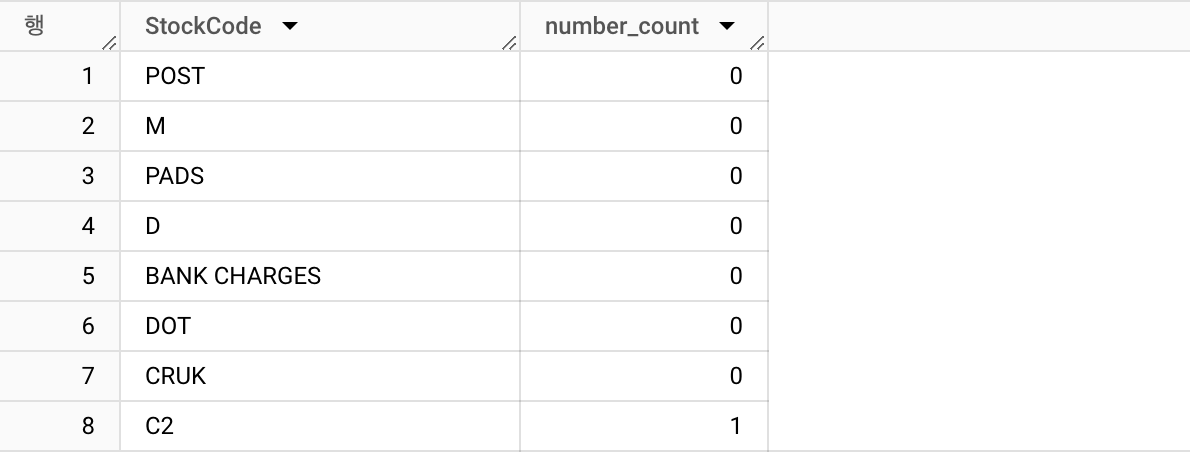

In [ ]:
SELECT concat(ROUND(SUM(CASE WHEN StockCode IN ('POST', 'M', 'PADS', 'D', 'BANK CHARGES', 'DOT', 'CRUK', 'C2') 
                        THEN 1 ELSE 0 END)/ COUNT(StockCode) * 100, 2), "%") as abnormal_StockCode
FROM first-metric-410915.modulabs_project.data

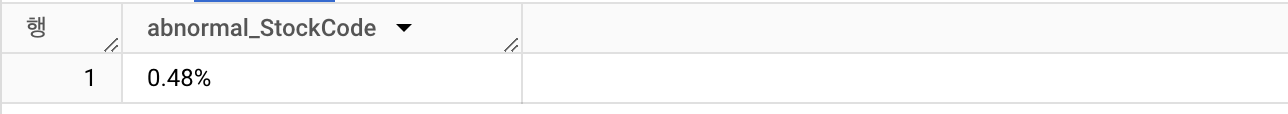

In [ ]:
DELETE FROM first-metric-410915.modulabs_project.data
WHERE StockCode IN (
  SELECT DISTINCT StockCode
  FROM (
  SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM first-metric-410915.modulabs_project.data
  ) 
WHERE number_count = 0 OR number_count = 1
)

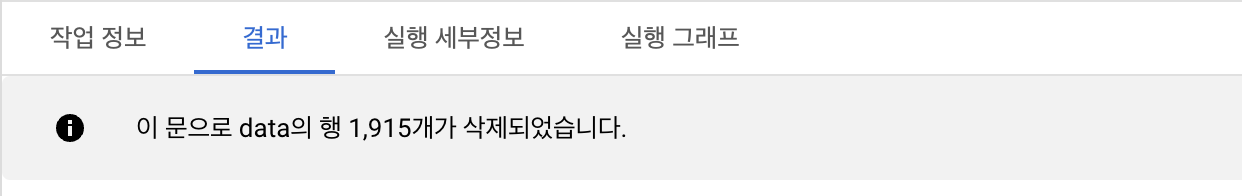

In [ ]:
SELECT Description, COUNT(*) AS description_cnt
FROM first-metric-410915.modulabs_project.data
GROUP BY 1
ORDER BY 2 DESC
LIMIT 30

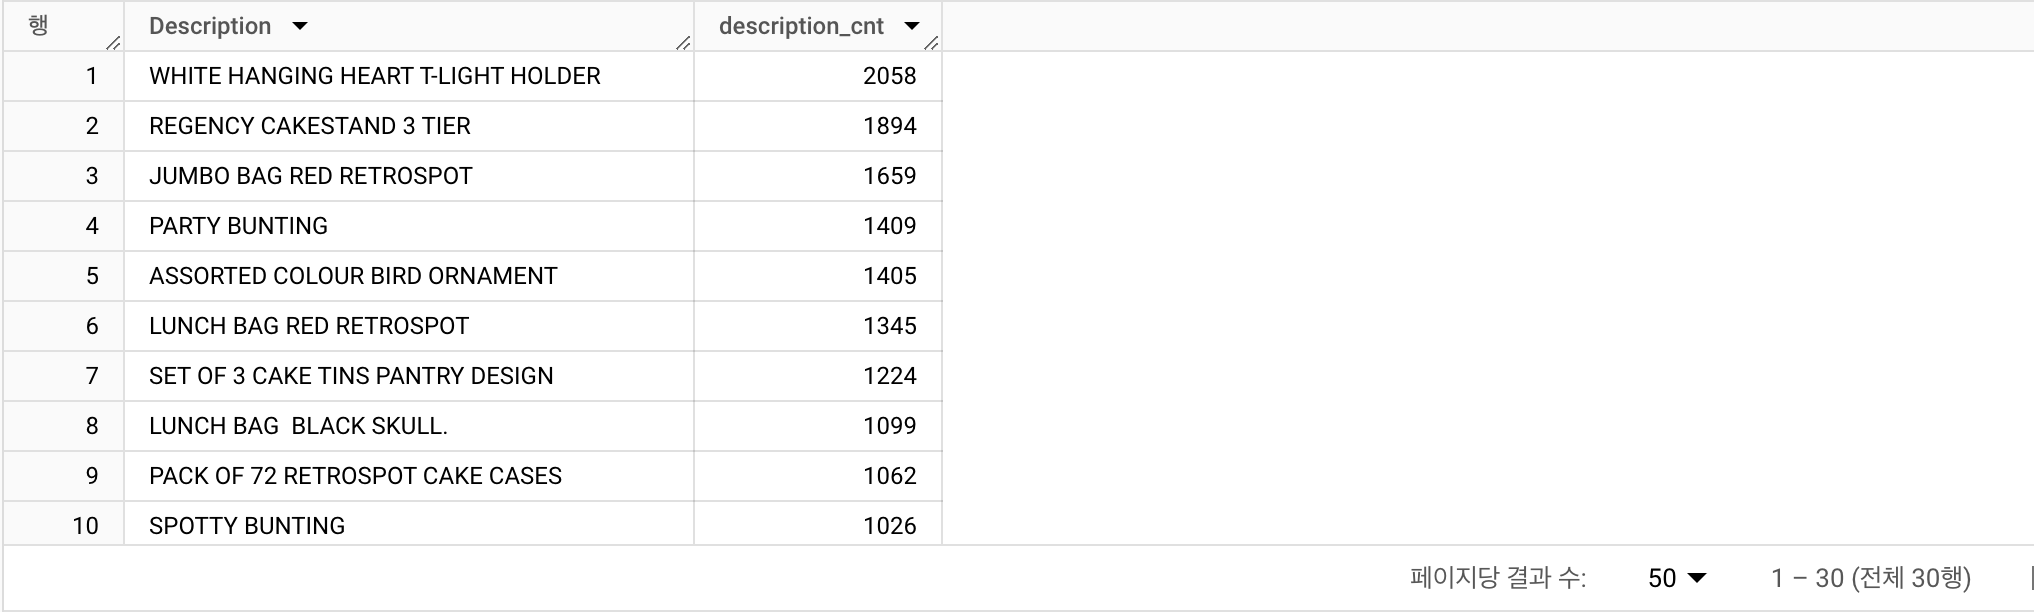

In [ ]:
SELECT DISTINCT Description
FROM first-metric-410915.modulabs_project.data
WHERE REGEXP_CONTAINS(Description, r'[a-z]')

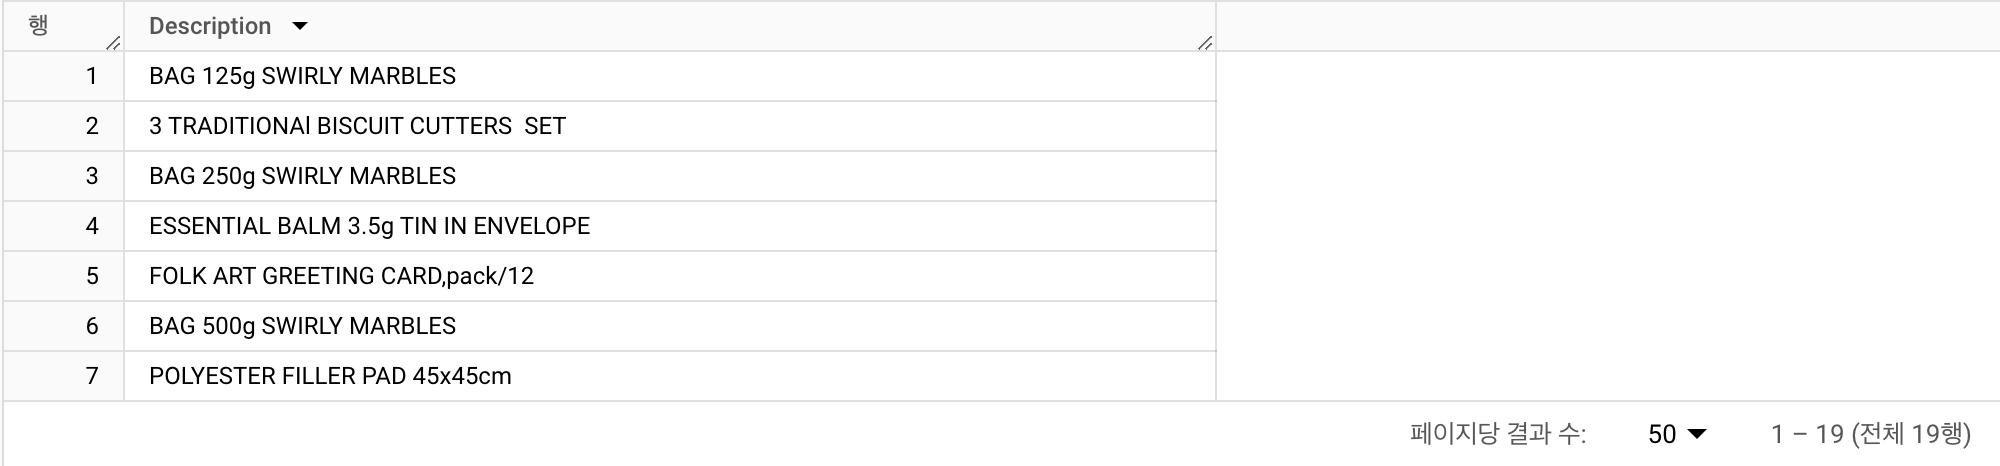

In [ ]:
DELETE
FROM first-metric-410915.modulabs_project.data
WHERE Description IN ('Next Day Carriage', 'High Resolution Image')

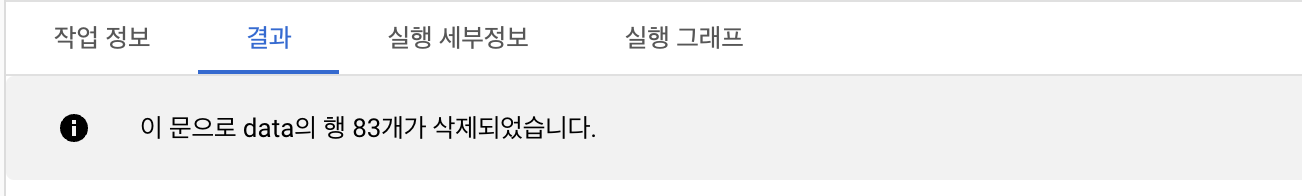

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.data AS
SELECT
  * EXCEPT (Description),
  UPPER(Description) AS Description
FROM first-metric-410915.modulabs_project.data

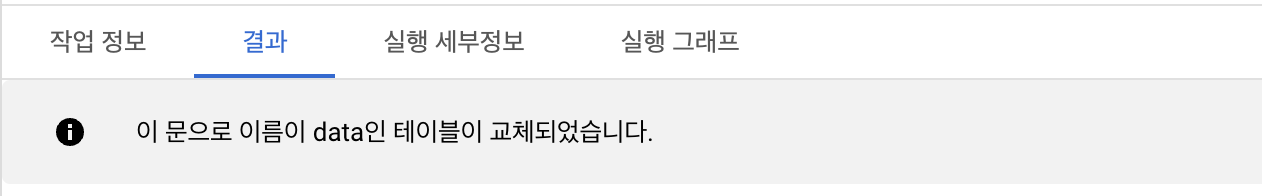

In [ ]:
select * FROM first-metric-410915.modulabs_project.data_updated WHERE InvoiceNo = '560538'

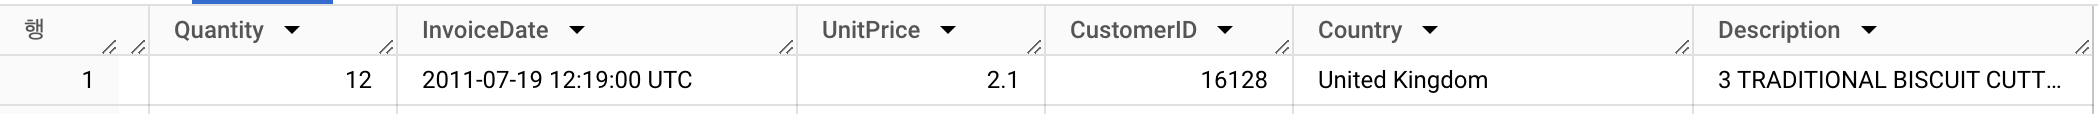

In [ ]:
SELECT COUNT(UnitPrice) AS cnt_quantity, MIN(Quantity) AS min_quantity, MAX(Quantity) AS max_quantity
, AVG(Quantity) AS avg_quantity
FROM first-metric-410915.modulabs_project.data
WHERE UnitPrice = 0

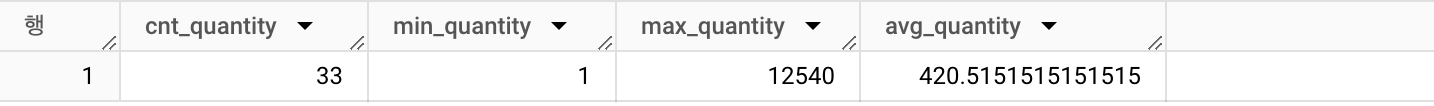

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.data AS 
SELECT *
FROM first-metric-410915.modulabs_project.data
WHERE UnitPrice = 0

### 불필요한 행 제거 
서비스 관련 정보('Next Day Carriage', 'High Resolution Image')포함하는 행들 33개 제거   
399606 → 399573(=399606-33)

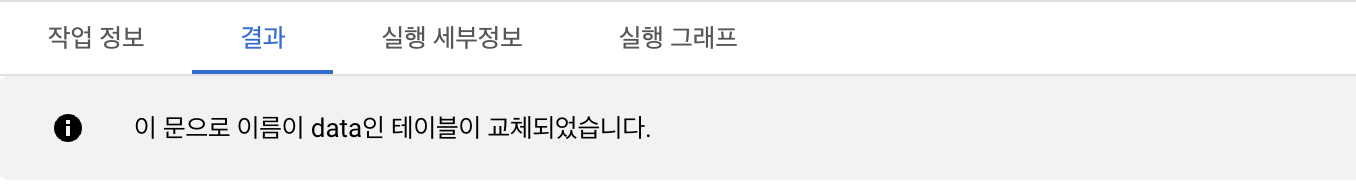

## 2. RFM 스코어

### Recency

In [ ]:
SELECT *
FROM first-metric-410915.modulabs_project.data;

CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.data AS
SELECT
  * EXCEPT (InvoiceDate),
  DATE(InvoiceDate) AS InvoiceDate
FROM first-metric-410915.modulabs_project.data;

SELECT *
FROM first-metric-410915.modulabs_project.data;

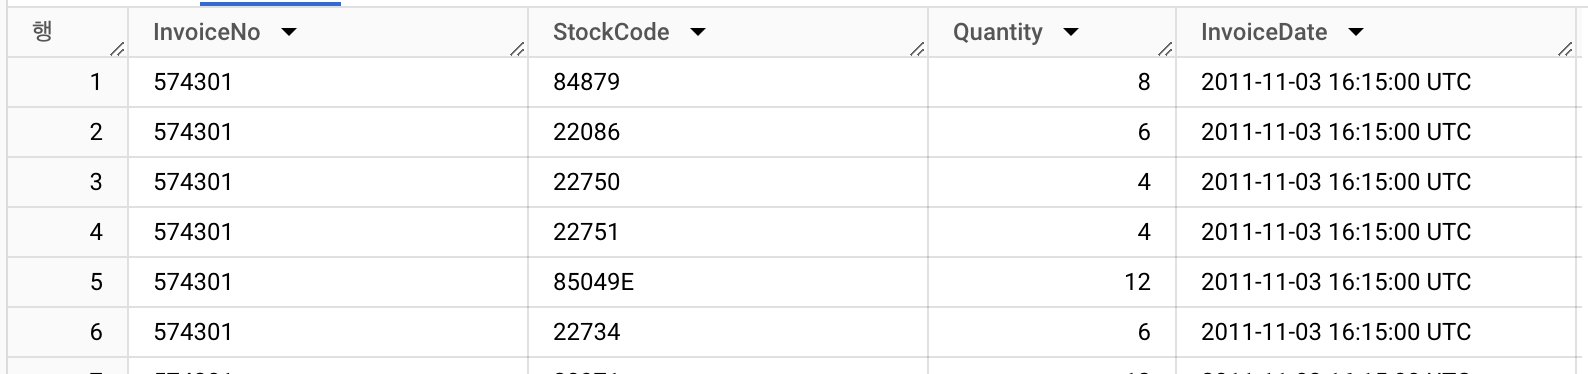
🔼 변경 전

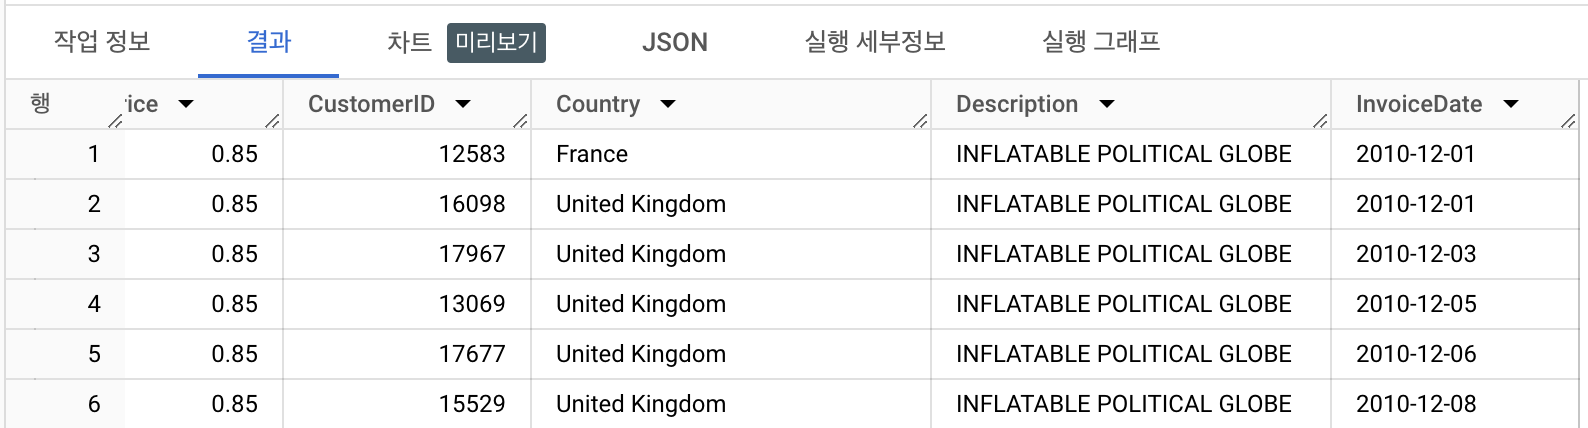
🔼 변경 후

In [ ]:
SELECT
    MAX(InvoiceDate) OVER () AS most_recent_date,
    InvoiceDate AS InvoiceDay,
    *
FROM first-metric-410915.modulabs_project.data;

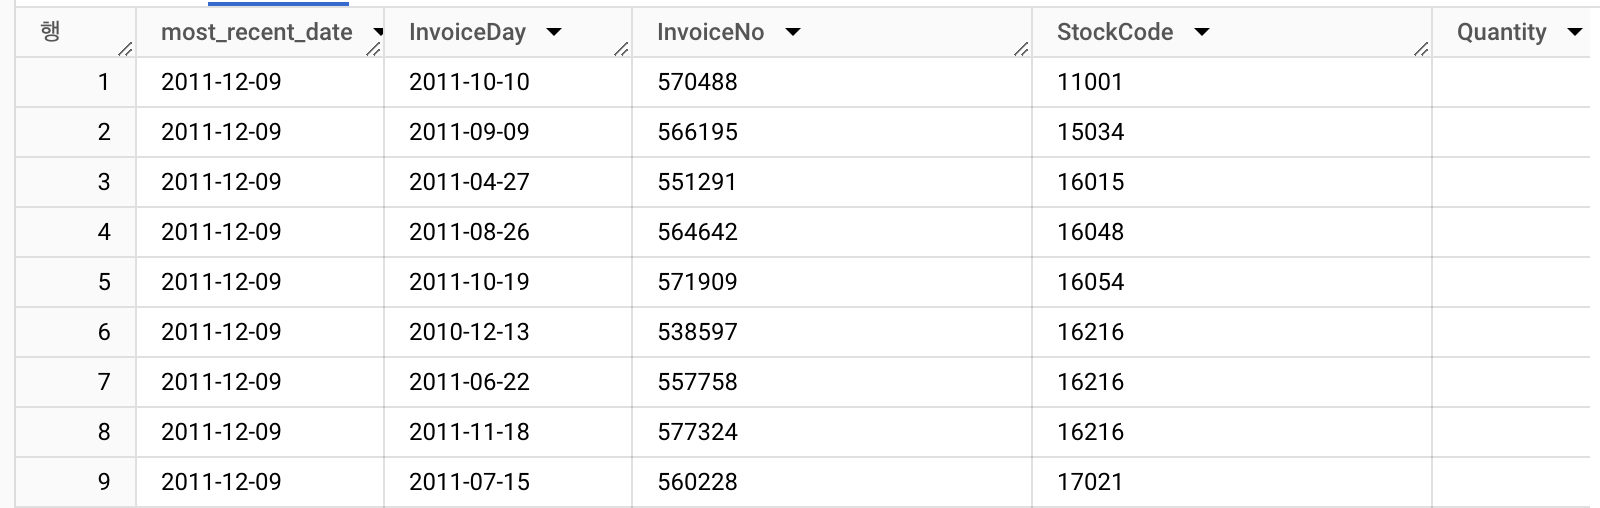

In [ ]:
SELECT
    CustomerID,
    MAX(InvoiceDate) AS InvoiceDay
FROM first-metric-410915.modulabs_project.data
GROUP BY 1
ORDER BY 1;

SELECT
    DISTINCT CustomerID,
    MAX(InvoiceDate) OVER (PARTITION BY CustomerID) AS InvoiceDay
FROM first-metric-410915.modulabs_project.data
ORDER BY 1;

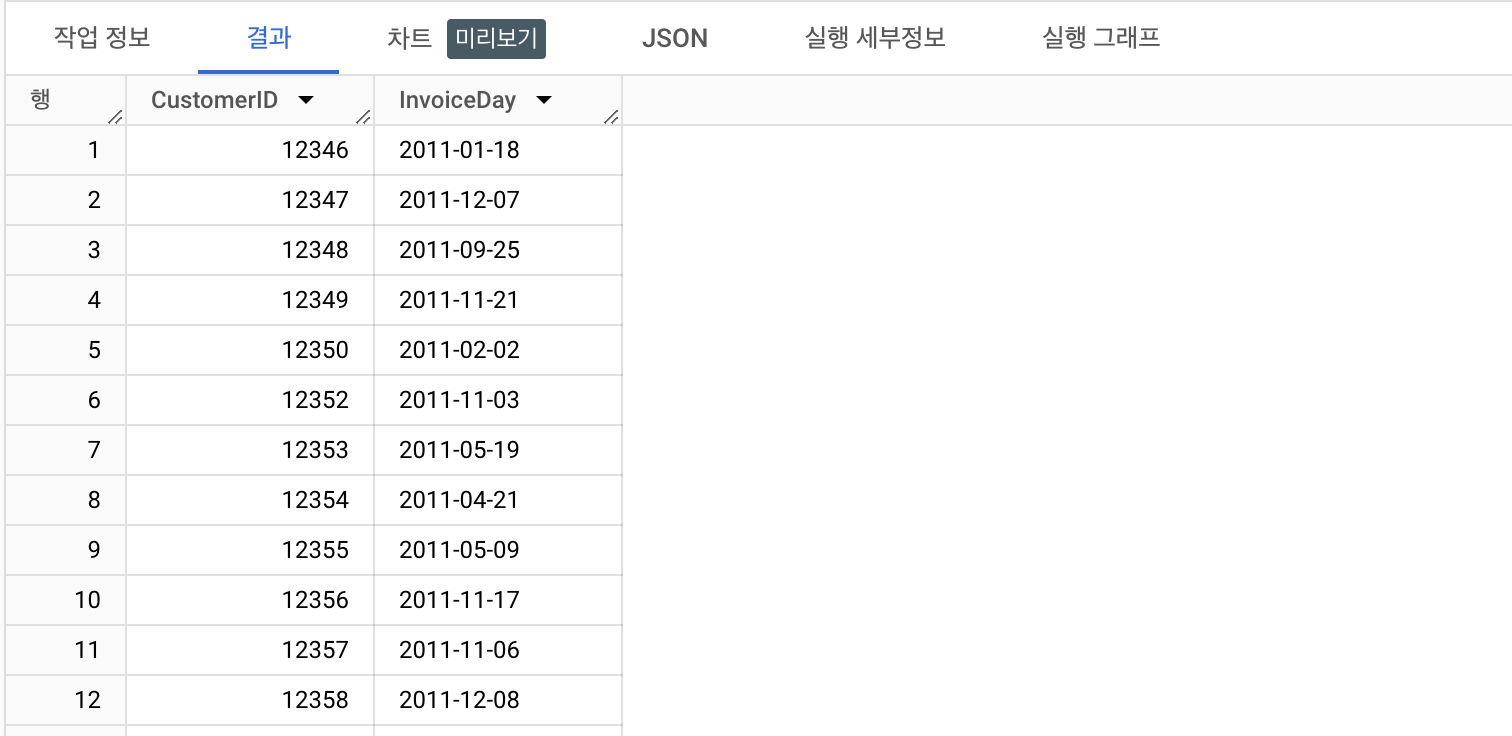

In [ ]:
SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)ORDER BY 1;

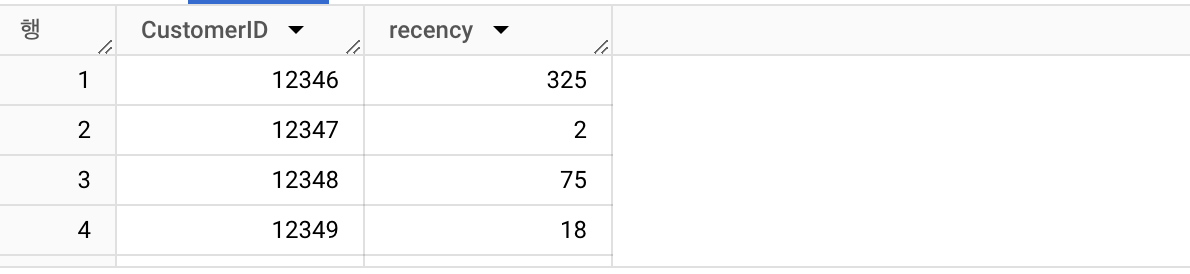

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_r AS
SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)

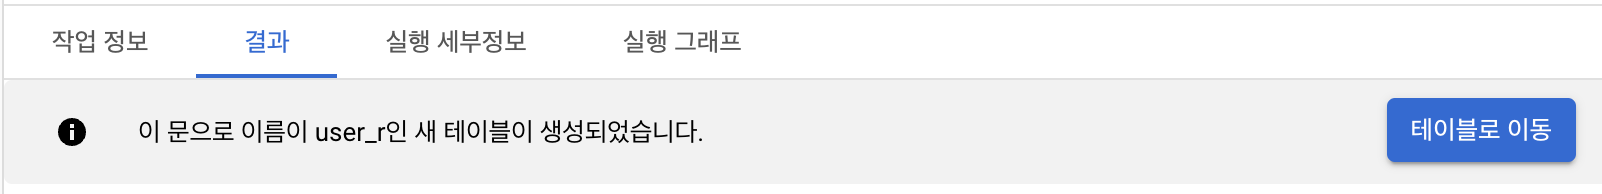

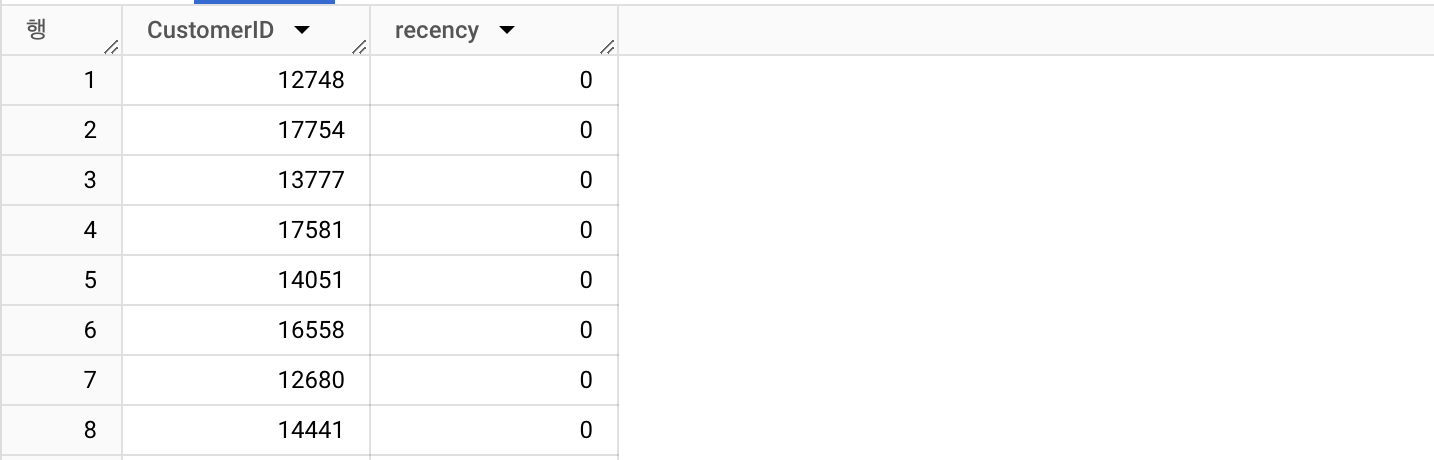
🔼 데이터 user_r

### Frequency

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_rf AS
-- (1) 전체 거래 건수 계산
WITH purchase_cnt AS ( 
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS purchase_cnt
  FROM first-metric-410915.modulabs_project.data
  GROUP BY 1
),
-- (2) 구매한 아이템 총 수량 계산
item_cnt AS (
  SELECT
    CustomerID,
    SUM(Quantity) AS item_cnt
  FROM first-metric-410915.modulabs_project.data
  GROUP BY 1
)
-- 기존의 user_r에 (1)과 (2)를 통합
SELECT
  pc.CustomerID,
  pc.purchase_cnt,
  ic.item_cnt,
  ur.recency
FROM purchase_cnt AS pc
JOIN item_cnt AS ic
  ON pc.CustomerID = ic.CustomerID
JOIN first-metric-410915.modulabs_project.user_r AS ur
  ON pc.CustomerID = ur.CustomerID;

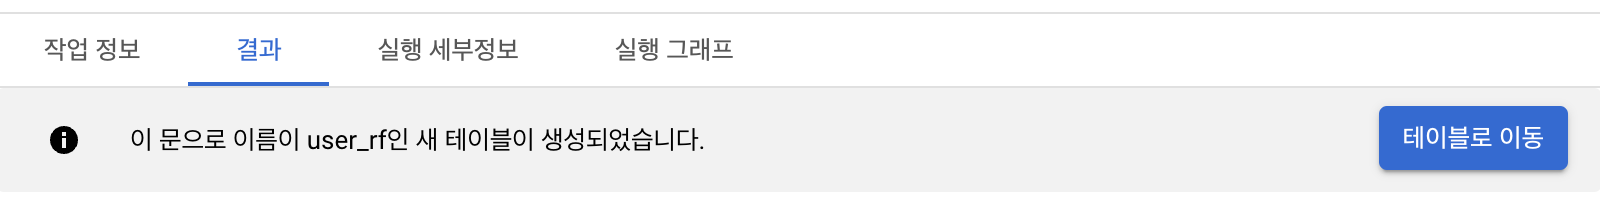

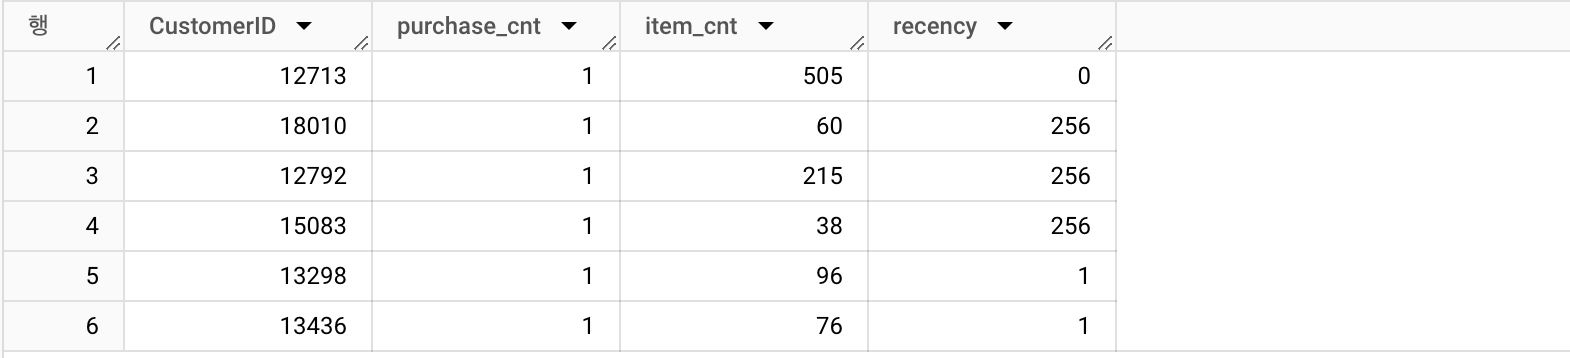
🔼 데이터 user_rf

### Monetary (1) 고객별 총 지출액 계산

In [ ]:
SELECT
  CustomerID,
  ROUND(SUM(Quantity * UnitPrice)) AS user_total
FROM first-metric-410915.modulabs_project.data
GROUP BY 1;

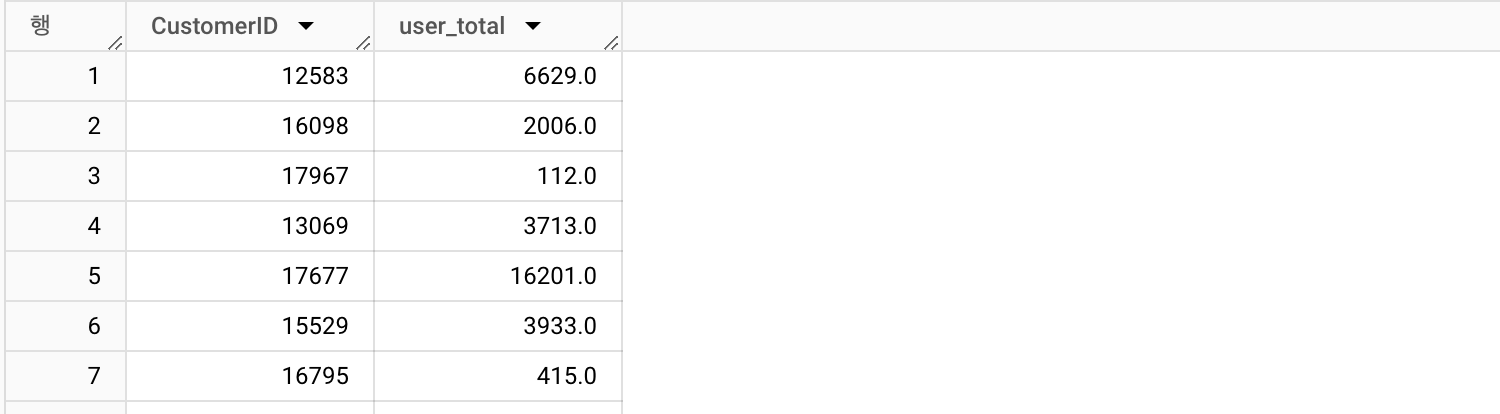

### Monetary (2) 고객별 평균 거래 금액 계산

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_rfm AS   
SELECT
  rf.CustomerID AS CustomerID,
  rf.purchase_cnt,
  rf.item_cnt,
  rf.recency,
  ut.user_total,
  ROUND(ut.user_total / rf.purchase_cnt) AS user_average
FROM first-metric-410915.modulabs_project.user_rf rf
LEFT JOIN (
  -- 고객 별 총 지출액
  SELECT
    CustomerID,
    ROUND(SUM(Quantity * UnitPrice)) AS user_total
  FROM first-metric-410915.modulabs_project.data
  GROUP BY 1
) ut
ON rf.CustomerID = ut.CustomerID;

SELECT *
FROM first-metric-410915.modulabs_project.user_rfm;

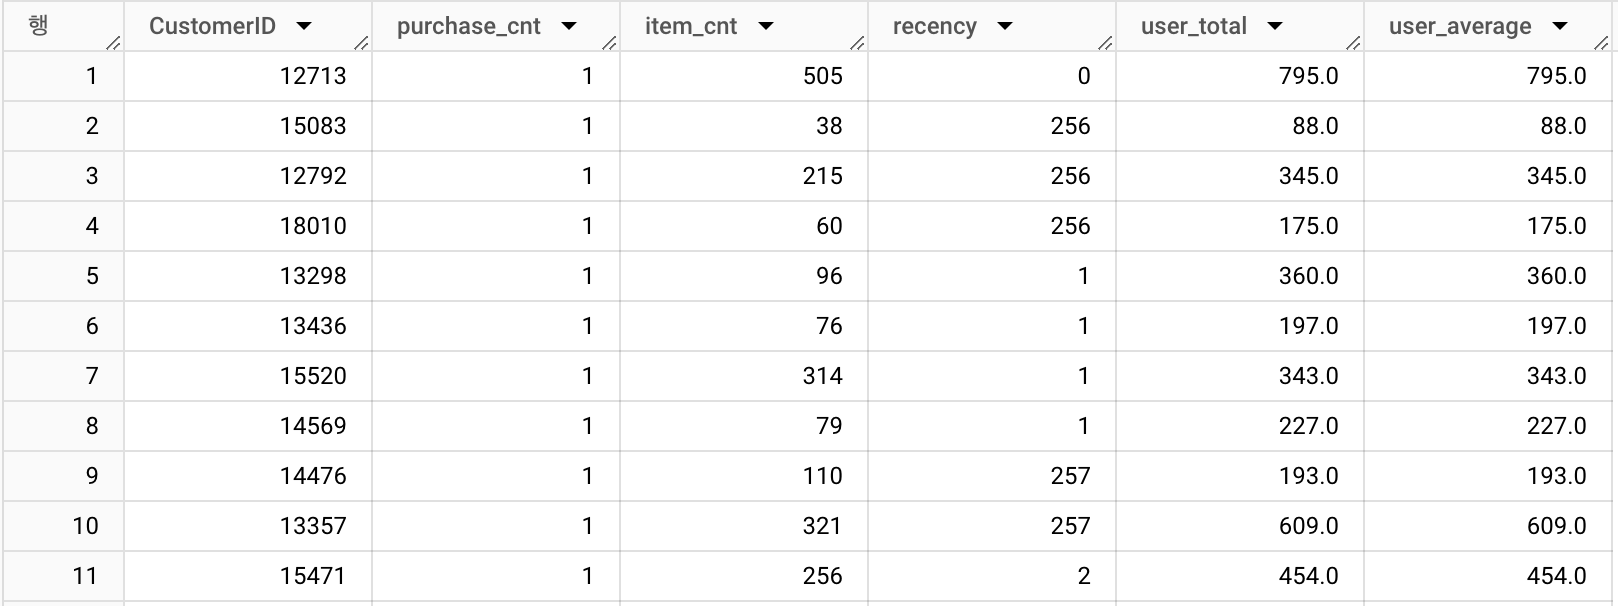
🔼 데이터 user_rfm

## 3. 추가 Feature 추출: 클러스터링 알고리즘

### 3-1. 구매하는 제품의 다양성

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_data AS  
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)
SELECT ur.*, up.* EXCEPT (CustomerID)
FROM first-metric-410915.modulabs_project.user_rfm AS ur
JOIN unique_products AS up
ON ur.CustomerID = up.CustomerID;

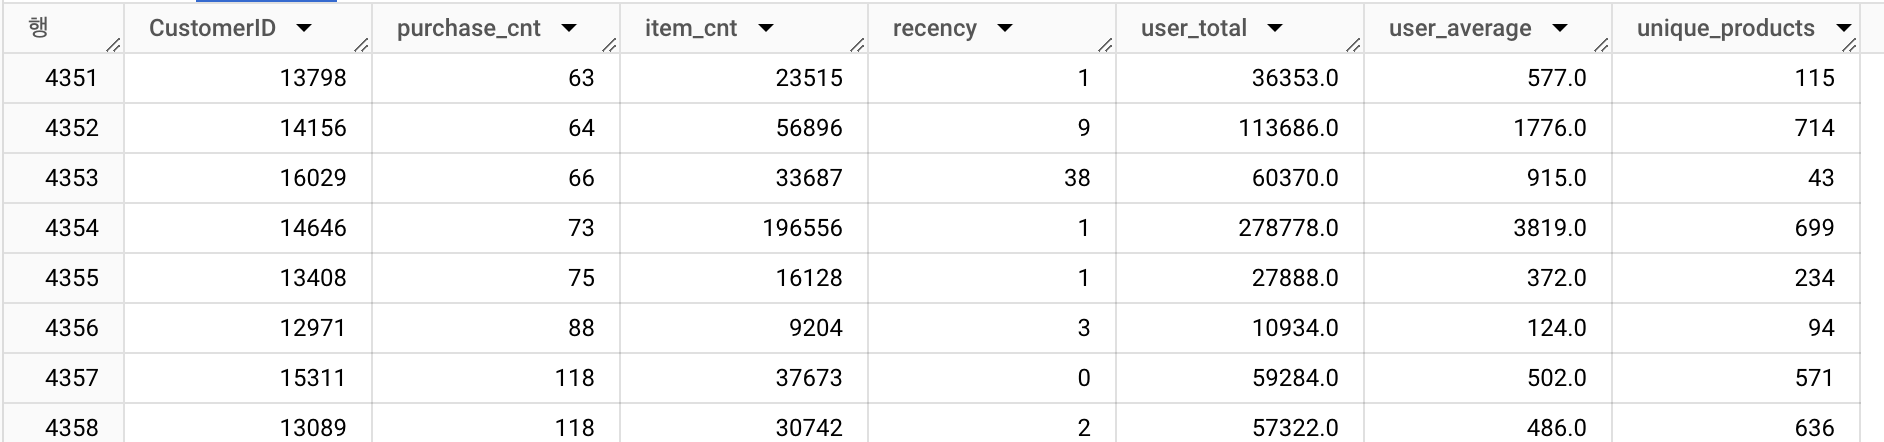
🔼 데이터 user_data

### 3-2. 평균 구매 주기

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_data AS
WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN ROUND(AVG(interval_), 2) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2) END AS average_interval
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF(InvoiceDate, LAG(InvoiceDate) OVER (PARTITION BY CustomerID ORDER BY InvoiceDate), DAY) AS interval_
    FROM
      first-metric-410915.modulabs_project.data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY CustomerID
)

SELECT u.*, pi.* EXCEPT (CustomerID)
FROM first-metric-410915.modulabs_project.user_data AS u
LEFT JOIN purchase_intervals AS pi
ON u.CustomerID = pi.CustomerID;


select * from first-metric-410915.modulabs_project.user_data

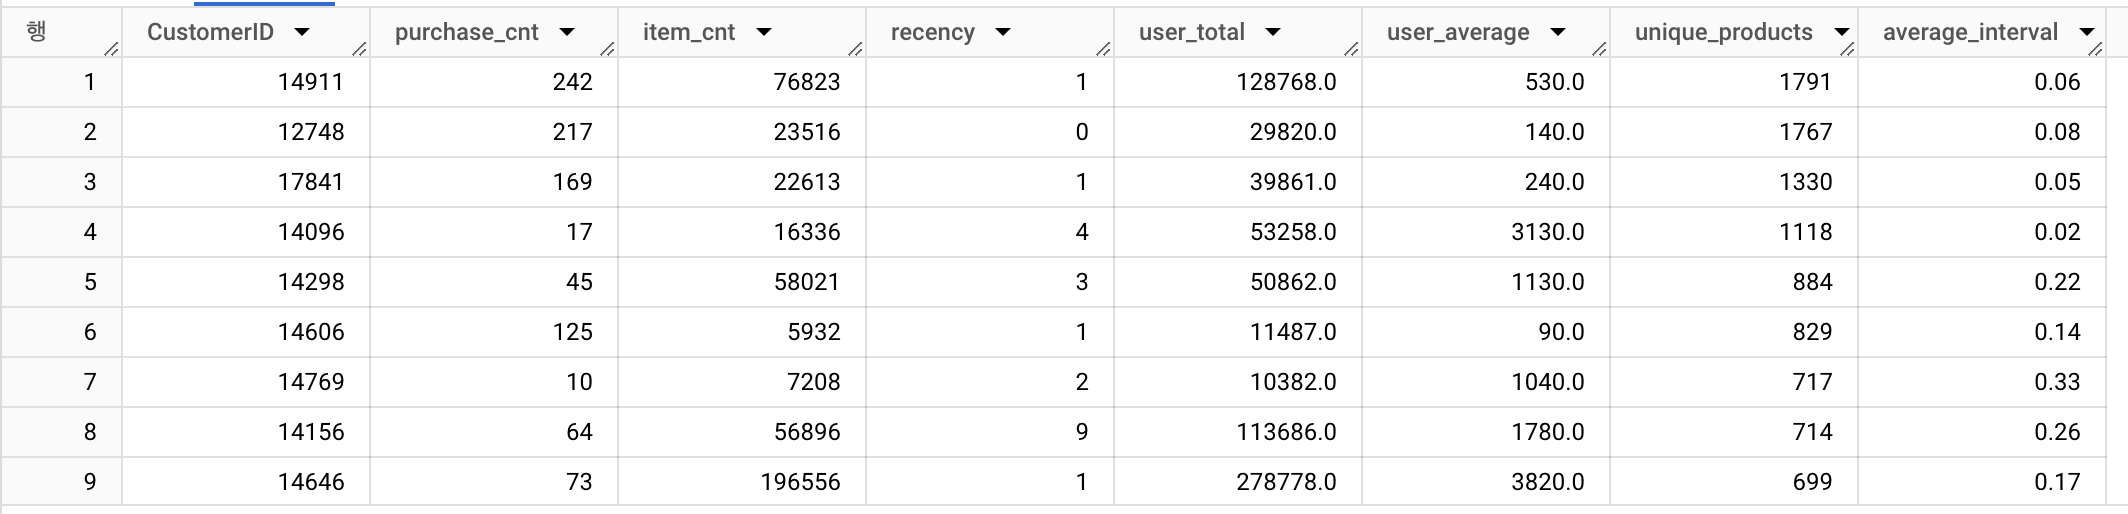
🔼 업데이트된 데이터 user_data

### 3-3. 구매 취소 경향성

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_data AS

WITH TransactionInfo AS (
  SELECT
    CustomerID,
    COUNT(InvoiceNo) AS total_transactions,
    COUNTIF(InvoiceNo LIKE 'C%') AS cancel_frequency
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)
SELECT u.*, t.* EXCEPT(CustomerID), ROUND(t.cancel_frequency / t.total_transactions * 100, 2) AS cancel_rate
FROM `first-metric-410915.modulabs_project.user_data` AS u
LEFT JOIN TransactionInfo AS t
ON u.CustomerID = t.CustomerID;

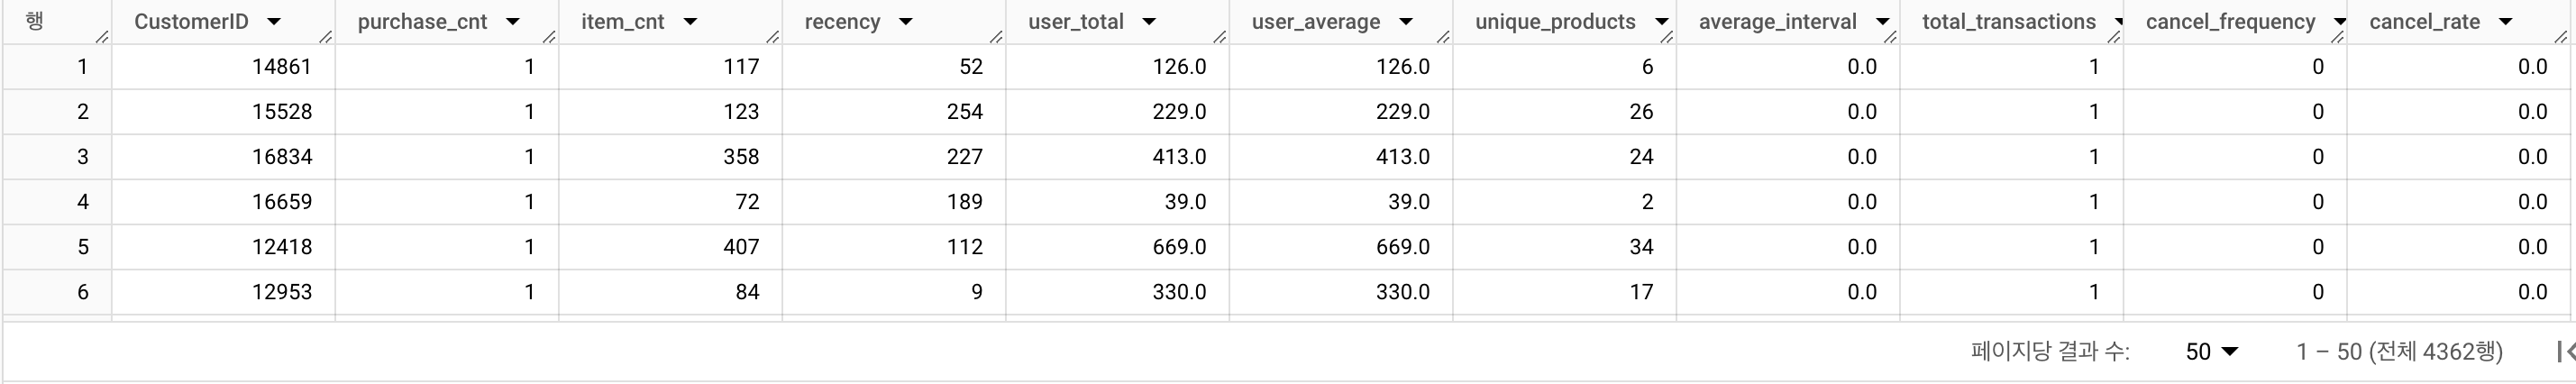
🔼 업데이트된 최종 데이터 user_data

### 결과 데이터 불러오기

In [6]:
import pandas as pd 
user_data = pd.read_csv('aiffel/customer_segmentation/user_DAta.csv')
user_data.head()

CustomerID  purchase_cnt  item_cnt  recency  user_total  user_average  \
0       16323             1        50      196       208.0         208.0   
1       16093             1        20      106        17.0          17.0   
2       16738             1         3      297         4.0           4.0   
3       15524             1         4       24       440.0         440.0   
4       17986             1        10       56        21.0          21.0   

   unique_products  average_interval  total_transactions  cancel_frequency  \
0                1               0.0                   1                 0   
1                1               0.0                   1                 0   
2                1               0.0                   1                 0   
3                1               0.0                   1                 0   
4                1               0.0                   1                 0   

   cancel_rate  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

## 회고 및 인사이트

1.  새롭게 배운 점
- 이전 노드에서 배운 RFM 적용 및 데이터 전처리. 생각보다 데이터 전처리 과정이 까다롭고 하나하나 생각해봐야 할 점이 많다. 단순히 Null 값과 중복값을 제외하는 정도라고 생각했던 것 같은데 각 데이터와 그 값이 어떤 의미인지 따져봐야 한다. 그 양이 방대한 경우에는 일부만 가지고 경향성을 판단할 수 없다. 
- 경향성 읽기
    - 예를 들어, United Kingdom에서 취소율이 높다라고 판단했는데(100 건중 2건 제외 모두) 알고보니 구매율 자체가 해당 국가에서 높았다.

2. 가장 시간이 오래 소요된 구간, 새로운 시도
- 임시테이블 만든 후 기존 테이블과 합치는 작업(Create, Replace)
    - WITH으로 만든 테이블에서 계산을 잘못하여 다시 시행하려고 하는데 이미 생성된 후라서, 컬럼명 중복에러가 났다.
    - 당연히 바로 덮어씌우기가 될 줄 알았는데 한 번 계산을 잘못하면 그냥 덮어쓰기로 단순히 처리가 되는 게 아니었다.

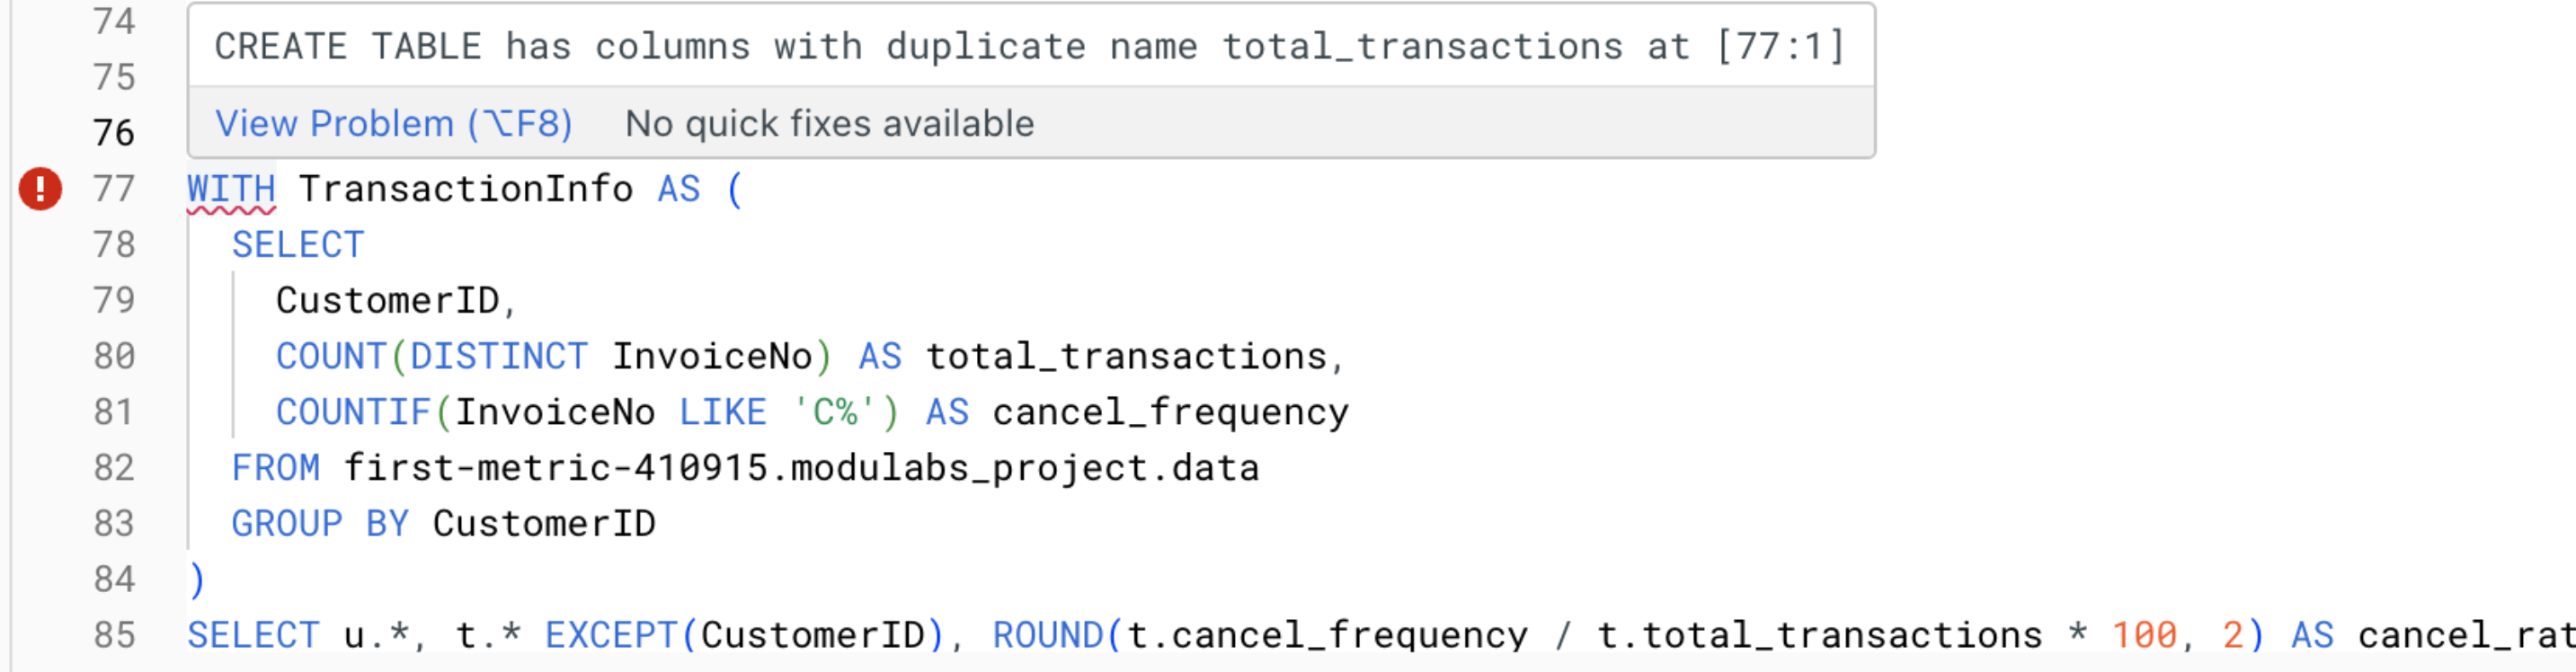
🔼 columns with duplicate Error

In [ ]:
CREATE OR REPLACE TABLE first-metric-410915.modulabs_project.user_data AS

WITH TransactionInfo AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS total_transactions,
    COUNTIF(InvoiceNo LIKE 'C%') AS cancel_frequency
  FROM first-metric-410915.modulabs_project.data
  GROUP BY CustomerID
)
SELECT u.*, t.* EXCEPT(CustomerID), ROUND(t.cancel_frequency / t.total_transactions * 100, 2) AS cancel_rate
FROM `first-metric-410915.modulabs_project.user_data` AS u
LEFT JOIN TransactionInfo AS t
ON u.CustomerID = t.CustomerID;

🔼 CREATE OR REPLACE TABLE 코드 일부

In [ ]:
-- total_transactions 컬럼 삭제
ALTER TABLE first-metric-410915.modulabs_project.user_data
DROP COLUMN total_transactions;

-- total_transactions 컬럼 추가
ALTER TABLE first-metric-410915.modulabs_project.user_data
ADD COLUMN total_transactions INT;

-- total_transactions 업데이트
UPDATE first-metric-410915.modulabs_project.user_data AS u
SET 
  total_transactions = (
    SELECT COUNT(DISTINCT InvoiceNo)
    FROM first-metric-410915.modulabs_project.data AS d
    WHERE d.CustomerID = u.CustomerID
  ),
  cancel_rate = (
    CASE 
      WHEN u.total_transactions > 0 THEN 
        ROUND(COUNTIF(InvoiceNo LIKE 'C%') / u.total_transactions * 100, 2)
      ELSE
        0
    END
  )
WHERE EXISTS (
    SELECT 1
    FROM first-metric-410915.modulabs_project.data AS d
    WHERE d.CustomerID = u.CustomerID
);

    - 그래서 alter, update를 써봤는데 기존 테이블에서 값을 참조해서 합치는 작업이라 단순하지 않았다.
    - user_data 테이블을 생성하는 작업은 어렵지 않아 결국 다시 지우고 새로 빠르게 만드는 게 가장 맘 편하다고 생각했다...
    - 그런데 만약에 아주아주 방대한 양의 작업이 이미 저장되어 있는 경우는 어떡하지? 그래서 한 번 해봤다.. 스텝엔 없지만..

3. 자기다짐 및 아쉬웠던 점
- 방향성을 잃는다. 궁금한 점이 생겨서 찾다보면 프로젝트와 거리가 있는 부분까지도 찾아보게 된다. 공부할 때는 깊이 파고드는 게 나쁜 것은 아니지만 오늘처럼 시간 내에 완수해야 하는 프로젝트가 있는 경우에는 적당히 끊어내고 다시 갈 길 가는 게 필요하다고 생각한다.

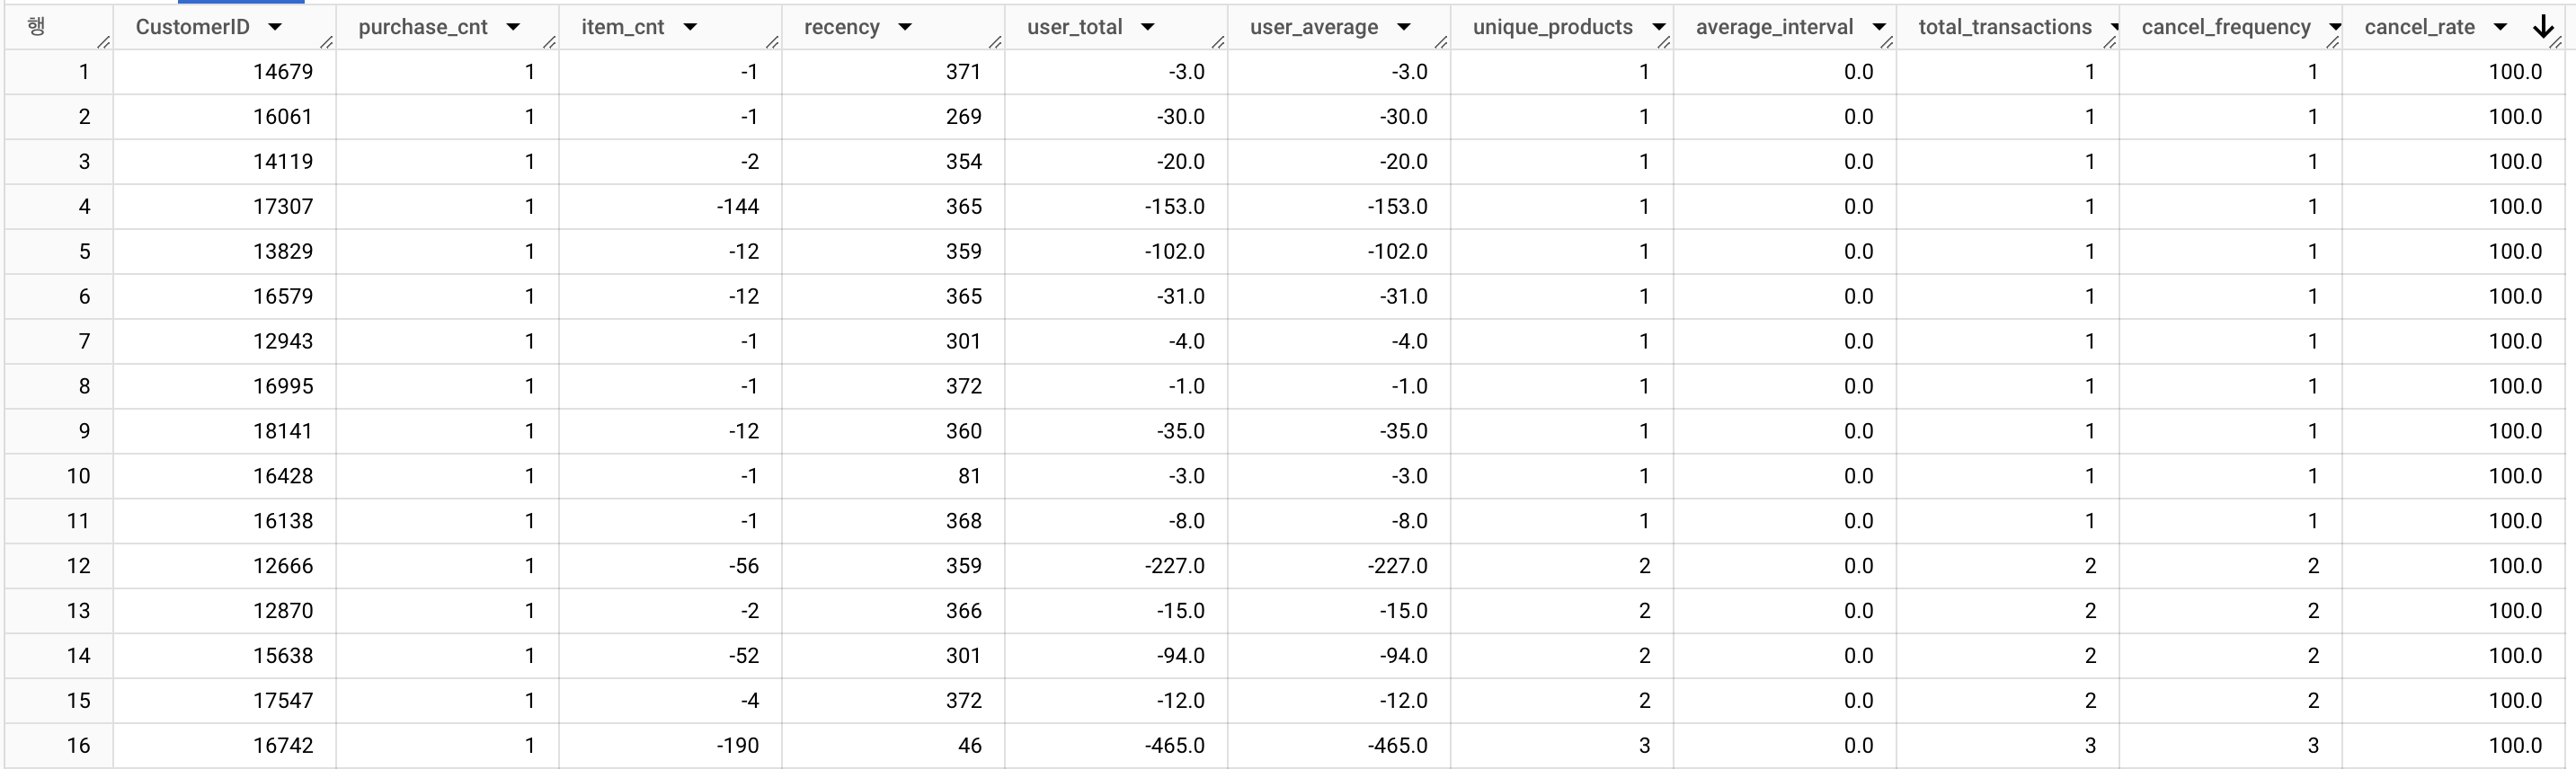
🔼 취소율 경향성 1

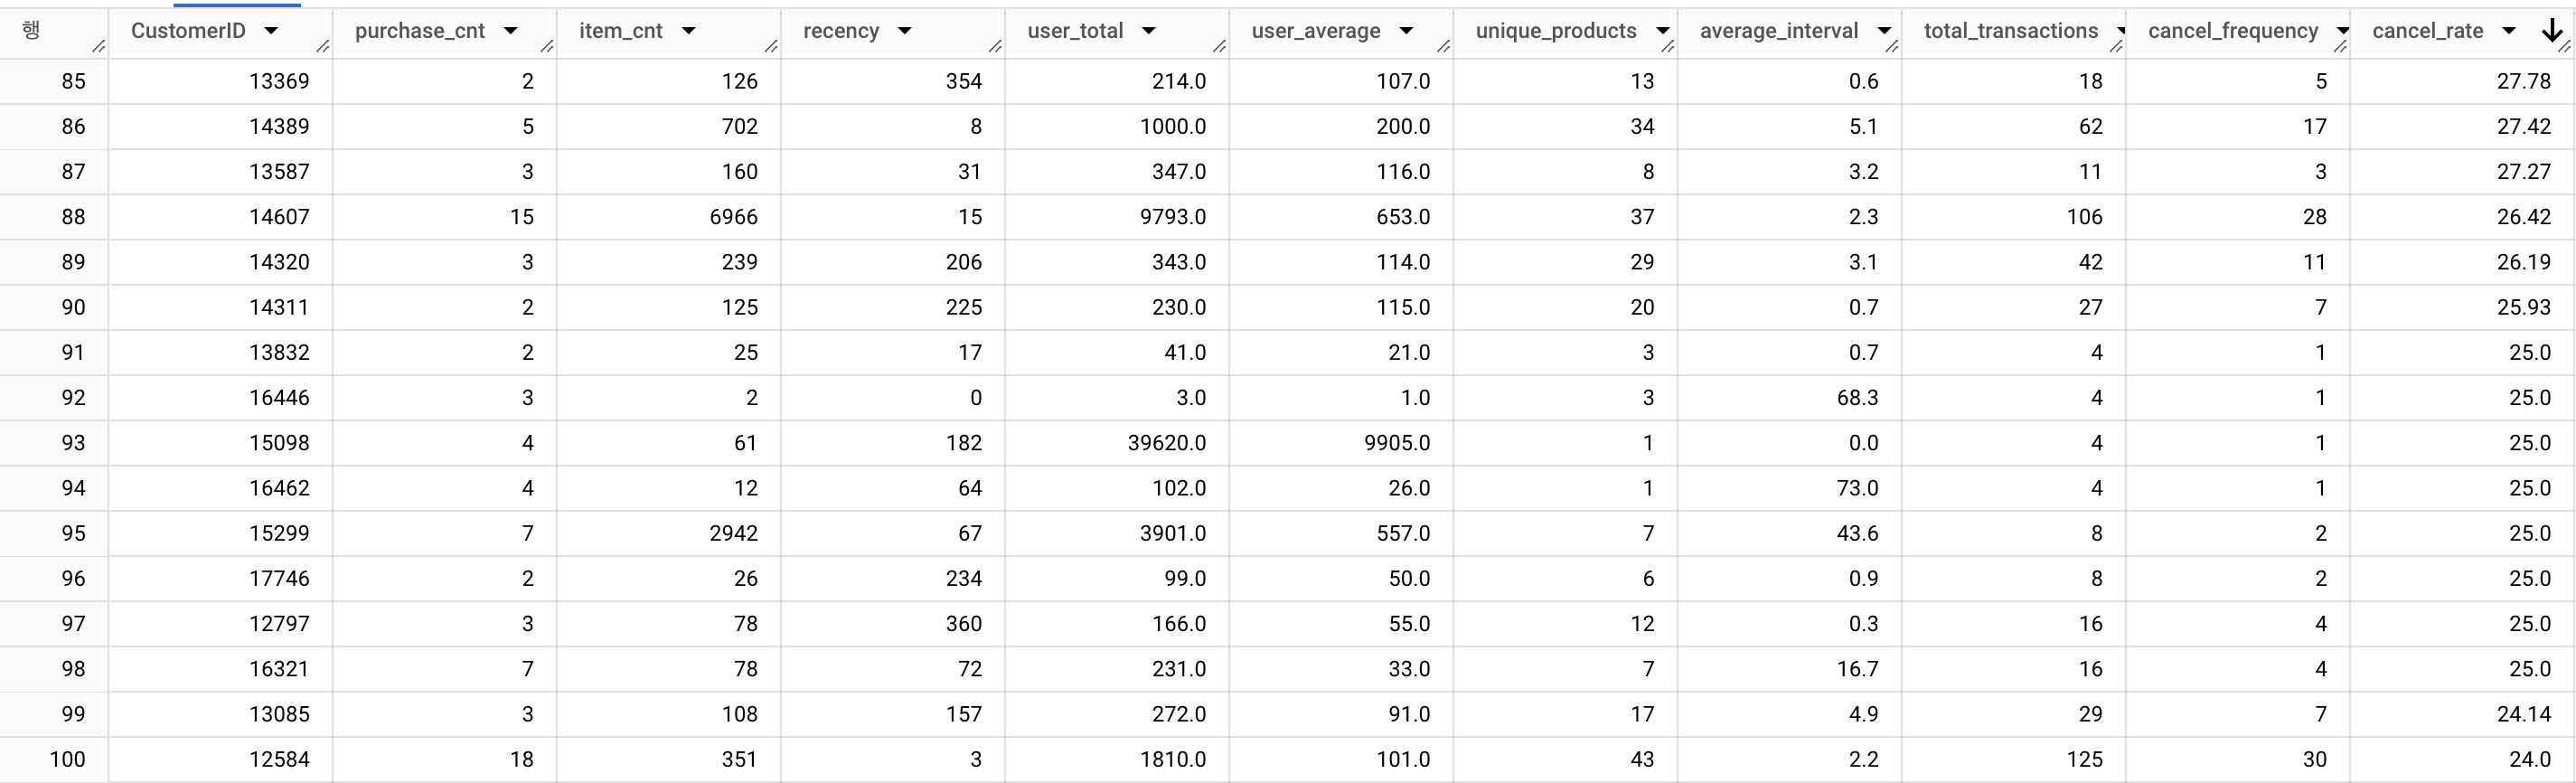
🔼 취소율 경향성 2